In [751]:
#run this command if not installed
#!pip install dimod

### Required Modules

In [752]:
#to visualize the network and easy handling of graphs I am using networkx
import networkx as gp
import matplotlib.pyplot as plt
import dimod
import math

In [753]:
#using inbuilt function to find shortest path
help(gp.shortest_simple_paths)

Help on function shortest_simple_paths in module networkx.algorithms.simple_paths:

shortest_simple_paths(G, source, target, weight=None)
    Generate all simple paths in the graph G from source to target,
       starting from shortest ones.
    
    A simple path is a path with no repeated nodes.
    
    If a weighted shortest path search is to be used, no negative weights
    are allowed.
    
    Parameters
    ----------
    G : NetworkX graph
    
    source : node
       Starting node for path
    
    target : node
       Ending node for path
    
    weight : string or function
        If it is a string, it is the name of the edge attribute to be
        used as a weight.
    
        If it is a function, the weight of an edge is the value returned
        by the function. The function must accept exactly three positional
        arguments: the two endpoints of an edge and the dictionary of edge
        attributes for that edge. The function must return a number.
    
        

In [754]:
#we will use pairwise function to convert the continuous nodes (representing path) into edges (where each edge is a node pair)
l= [1,2,4,5,2,4]
ed = list(gp.utils.pairwise(l))
print(ed)

[(1, 2), (2, 4), (4, 5), (5, 2), (2, 4)]


### Sample Input Data

In [755]:
#sample data - to be read from file
#total number of nodes
num_nodes = 6
#Edges are given as u,v,congestion where edges is from u to v and its congestion level is given by the attribute congestion
edges = [
    (0, 1, {'congestion': 2, 'distance': 2}),
    (1, 2, {'congestion': 10, 'distance': 2}),
    (2, 3, {'congestion': 1, 'distance': 2}),
    (3, 4, {'congestion': 20, 'distance': 1}),
    (0, 5, {'congestion': 1, 'distance': 3}),
    (5, 6, {'congestion': 5, 'distance': 3}),
    (6, 4, {'congestion': 1, 'distance': 2}),
    (1, 3, {'congestion': 15, 'distance': 2}),
    (0, 3, {'congestion': 5, 'distance': 3})
]
'''edges = [
    (0,1,{'congestion':100, 'distance':40}),
    (0,2,{'congestion':10, 'distance':30}),
    (1,3,{'congestion':200, 'distance':260}),
    (1,4,{'congestion':110, 'distance':100}),
    (2,4,{'congestion':10, 'distance':500}),
    (2,5,{'congestion':12, 'distance':300}),
    (3,4,{'congestion':35, 'distance':6000}),
    (4,2,{'congestion':54, 'distance':300}),
    (0,5,{'congestion':200, 'distance':50}),
    (0,3,{'congestion':50, 'distance':3000})
]'''
#total number of cars to reroute
no_of_cars = 2
#source-destination pair of each car
src_dest = [(0,4,1),(0,4,0)]

## Graph formation using NetworkX

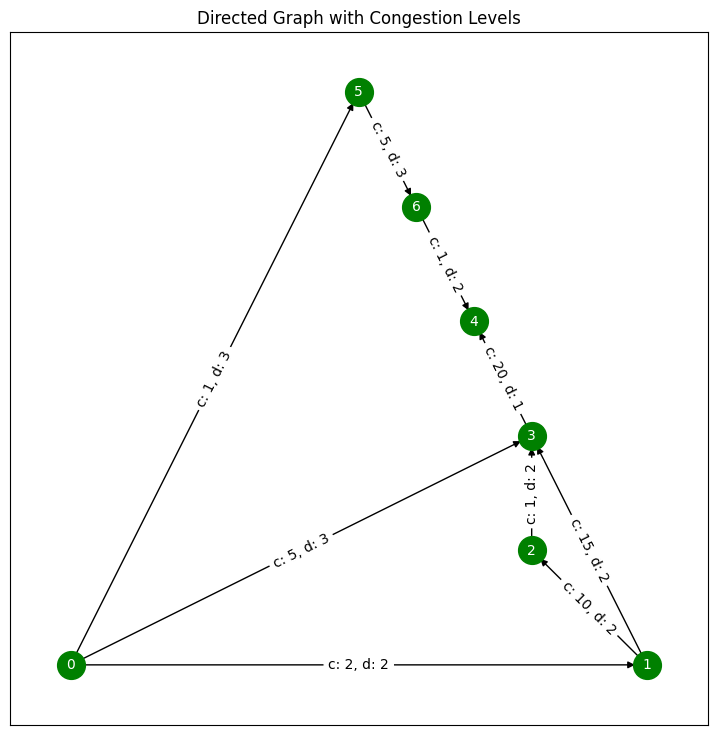

In [756]:
#forming the city's network
#adding nodes
net = gp.DiGraph()
net.add_edges_from(edges)
plt.figure(figsize=(9,9))
pos = gp.planar_layout(net)
gp.draw_networkx_nodes(net, pos, node_color='green', node_size=400)
gp.draw_networkx_edges(net, pos, arrowstyle='-|>', arrowsize=10)
edge_labels = {(u, v): f'c: {d["congestion"]}, d: {d["distance"]}' for u, v, d in net.edges(data=True)}
gp.draw_networkx_edge_labels(net, pos, edge_labels=edge_labels)
gp.draw_networkx_labels(net, pos, font_size=10, font_color='white')
plt.title("Directed Graph with Congestion Levels")
plt.show()

### Alternative Routes

In [757]:
def nodeToEdge(node_routes,no_of_car, no_of_route):
    '''the function convert the route in nodes format to edge format (pairwise nodes as shown above)'''
    edge_route = []
    for i in range(no_of_car):
        car_route = []
        for j in range(no_of_route):
                car_route.append(list(gp.utils.pairwise(node_routes[i][j])))
        edge_route.append(car_route)
    return edge_route

In [758]:
def calcJCS(set_a, set_b):
    '''
    the function calculates the jaccard similarity index of two given paths
    '''
    inter = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return inter/union if union !=0 else 0
def jaccardSimilarityIndex(paths):
    '''
    the function returns the three paths which have least Jaccard Similarity index
    '''
    k = len(paths)
    route = [paths]
    route = nodeToEdge(route,1,k)
    route = route[0]
    result = {}
    for i in range(k):
        for j in range(i+1,k):
            set_a = set(route[i])
            set_b = set(route[j])
            similarity = calcJCS(set_a, set_b)
            result.update({(i,j):similarity})
    srf = sorted(result.items(), key=lambda x: x[1])
    sr=srf[0][0]
    sr2 = srf[1][0]
    final_paths = [paths[sr[0]],paths[sr[1]]]
    if sr2[0] not in sr:
        final_paths.append(paths[sr2[0]])
    else:
        final_paths.append(paths[sr2[1]])
    return final_paths

def edgeWeight(u,v,d):
    return d.get('congestion')/d.get('distance')

def alternativeRoutes(no_of_cars, sd):
    '''finds all the simple paths from source to destination for each car'''
    routes = []
    for i in range(no_of_cars):
        k_paths = list(gp.shortest_simple_paths(net, source = sd[i][0], target=sd[i][1], weight = edgeWeight))
        k_paths = jaccardSimilarityIndex(k_paths)
        routes.append(k_paths)
    return routes
    #return [[[0,1,4],[0,1,3,4],[0,2,4]],[[0,2,5],[0,1,3,4,5],[0,1,4,5]]]

In [759]:
routes  = alternativeRoutes(no_of_cars,src_dest )
print("Source-Destination Pairs for Rerouting:")
for src, dest,emergency in src_dest:
    print(f"Car starting from {src} to {dest} : emergency {emergency}")
print('\nAlternative Routes :\n')
index = 0
for i in range(1,3):
    print(f'Possible Routes for Car {i}')
    for ch in range(0,len(routes[0])):
        l=[]
        for path in routes[i-1][ch]:
            l.append(str(path))
        c="->"
        print(index,":",c.join(l))
        index+=1
        print()

Source-Destination Pairs for Rerouting:
Car starting from 0 to 4 : emergency 1
Car starting from 0 to 4 : emergency 0

Alternative Routes :

Possible Routes for Car 1
0 : 0->5->6->4

1 : 0->3->4

2 : 0->1->2->3->4

Possible Routes for Car 2
3 : 0->5->6->4

4 : 0->3->4

5 : 0->1->2->3->4



### Helping Functions

In [760]:
def getOverlappingEdges(route1, route2):
    '''the function returns a list of overlapping edges (pairwise-nodes)'''
    overlaps =[]
    for r1 in route1:
        if r1 in route2:
            overlaps.append(r1)
    return overlaps

In [761]:
def getNonOverlappingEdges(route):
    '''
    returns the unique elements in an array
    '''
    uni = []
    for edge in route:
        if edge not in uni:
            uni.append(edge)
    return uni

In [762]:
def matrixWeight(route_edge, no_of_cars, no_of_routes):
        '''
        forms the weight matrix (W(ij)) for each binary variable
        '''
        Q_weight = {}
        for i in range(no_of_cars):
            emergency = src_dest[i][2]
            for j in range(no_of_routes):
                path = route_edge[i][j]
                path_weight = 0
                total_congestion = 0
                total_distance = 0
                for x, y in path:
                    congestion = net[x][y]['congestion']
                    distance = net[x][y]['distance']
                    total_congestion += congestion
                    total_distance += distance
                total_congestion/=len(path)
                total_distance/=len(path)
                path_weight = (1 * total_congestion) + (0.5*total_distance)
                if emergency == 0:
                    path_weight += 50
                Q_weight.update({(i, j): round(path_weight, 3)})
            print(emergency)
        print(Q_weight)
        return Q_weight
    

In [763]:
def displayMatrix(Q):
    print("-"*50)
    for i in range(0,6):
        for j in range(0,6):
            print(round(Q.get((i,j)),3),"\t|", end="\t")
        print()
        print("-"*50)
    print()

In [764]:
def formQuboMatrix(routes, no_of_car, no_of_routes):
    '''
    forms the QUBO matrix in the form of dictionary
    '''
    #dictionary Q will store the qubo matrix
    Q = {}
    K = 0 # initializing penalty factor
    W = matrixWeight(routes, no_of_car, no_of_routes)
    tot_var = no_of_car*no_of_routes
    #initializing the matrix values to 0
    for i in range(tot_var):
        for j in range(tot_var):
            Q.update({(i,j):0})
    #adding cost function terms
    for i in range(no_of_car):
        for j in range(no_of_routes):
            tot_overlap = []
            for k in range(i+1, no_of_car):
                for m in range(no_of_routes):
                    list_of_overlap = getOverlappingEdges(routes[i][j], routes[k][m])
                    #print(list_of_overlap)
                    Q.update({(i*no_of_routes + j, k*no_of_routes + m):2*len(list_of_overlap)*W[(i,j)]*W[(k,m)]})
                    tot_overlap.extend(list_of_overlap)
            uni_overlap = getNonOverlappingEdges(tot_overlap)
            Q.update({(i*no_of_routes + j, i*no_of_routes + j):len(uni_overlap)*W[(i,j)]*W[(i,j)]})
    #adding penalty terms
    K=10000
    for i in range(no_of_car):
        for j in range(no_of_routes):
            for m in range(j+1, no_of_routes):
                Q.update({(i*no_of_routes + j, i*no_of_routes + m):K*2})
            Q[(i*no_of_routes + j, i*no_of_routes + j)] -= K;
    return Q 

In [765]:
routes  = alternativeRoutes(no_of_cars,src_dest)
no_of_routes = len(routes[0])
routes_edge = nodeToEdge(routes,no_of_cars,no_of_routes)
Q = formQuboMatrix(routes_edge, no_of_cars, no_of_routes)
#Q will be an upper triangle matrix
print("QUBO Matrix : for 2 cars and 3 alternative route ( 6 x 6 matrix )")
displayMatrix(Q)

1
0
{(0, 0): 3.667, (0, 1): 13.5, (0, 2): 9.125, (1, 0): 53.667, (1, 1): 63.5, (1, 2): 59.125}
QUBO Matrix : for 2 cars and 3 alternative route ( 6 x 6 matrix )
--------------------------------------------------
-9959.659 	|	20000 	|	20000 	|	1180.781 	|	0.0 	|	0.0 	|	
--------------------------------------------------
0 	|	-9635.5 	|	20000 	|	0.0 	|	3429.0 	|	1596.375 	|	
--------------------------------------------------
0 	|	0 	|	-9666.938 	|	0.0 	|	1158.875 	|	4316.125 	|	
--------------------------------------------------
0 	|	0 	|	0 	|	-10000.0 	|	20000 	|	20000 	|	
--------------------------------------------------
0 	|	0 	|	0 	|	0 	|	-10000.0 	|	20000 	|	
--------------------------------------------------
0 	|	0 	|	0 	|	0 	|	0 	|	-10000.0 	|	
--------------------------------------------------



In [766]:
#runnign the classical solver 
bqm = dimod.BinaryQuadraticModel.from_qubo(Q)
exact_solver  = dimod.ExactSolver()
response = exact_solver.sample(bqm)
result = list(response.samples())
print(response)
resulting_energy = list(response.data_vectors['energy'])
min_energy = min(resulting_energy)
ct = resulting_energy.count(min_energy)
best_result = []
for i in range(ct):
    best_result.append(list(dict.values(dict(result[i]))))

    0  1  2  3  4  5        energy num_oc.
30  1  0  0  0  1  0 -19959.659333       1
62  1  0  0  0  0  1 -19959.659333       1
8   0  0  1  1  0  0   -19666.9375       1
12  0  1  0  1  0  0      -19635.5       1
14  1  0  0  1  0  0 -18778.877999       1
24  0  0  1  0  1  0   -18508.0625       1
60  0  1  0  0  0  1    -18039.125       1
28  0  1  0  0  1  0      -16206.5       1
56  0  0  1  0  0  1   -15350.8125       1
15  0  0  0  1  0  0      -10000.0       1
31  0  0  0  0  1  0      -10000.0       1
63  0  0  0  0  0  1      -10000.0       1
1   1  0  0  0  0  0  -9959.659333       1
33  1  0  0  0  1  1  -9959.659333       1
7   0  0  1  0  0  0    -9666.9375       1
3   0  1  0  0  0  0       -9635.5       1
11  0  1  1  1  0  0    -9302.4375       1
17  1  0  0  1  1  0  -8778.877999       1
49  1  0  0  1  0  1  -8778.877999       1
23  0  0  1  1  1  0    -8508.0625       1
25  1  0  1  0  1  0  -8467.721833       1
9   1  0  1  1  0  0  -8445.815499       1
13  1  1  0

In [767]:
print("minimum energy :",min_energy)
car1_nodes = []
car2_nodes = []
for sol in best_result:
    print("Possible Solution :", sol)
    ind = 0
    for i in range(no_of_cars):
        for j in range(no_of_routes):
            if(sol[ind]==1):
                    print(f'best route for car {i+1}: {routes[i][j]}')
                    if(i==0):car1_nodes = routes[i][j]
                    if(i==1):car2_nodes = routes[i][j]
            ind+=1

minimum energy : -19959.659333
Possible Solution : [1, 0, 0, 0, 0, 1]
best route for car 1: [0, 5, 6, 4]
best route for car 2: [0, 1, 2, 3, 4]
Possible Solution : [1, 0, 0, 0, 1, 0]
best route for car 1: [0, 5, 6, 4]
best route for car 2: [0, 3, 4]


Best Solution
Blue represent Car 1 , Green represents Car 2


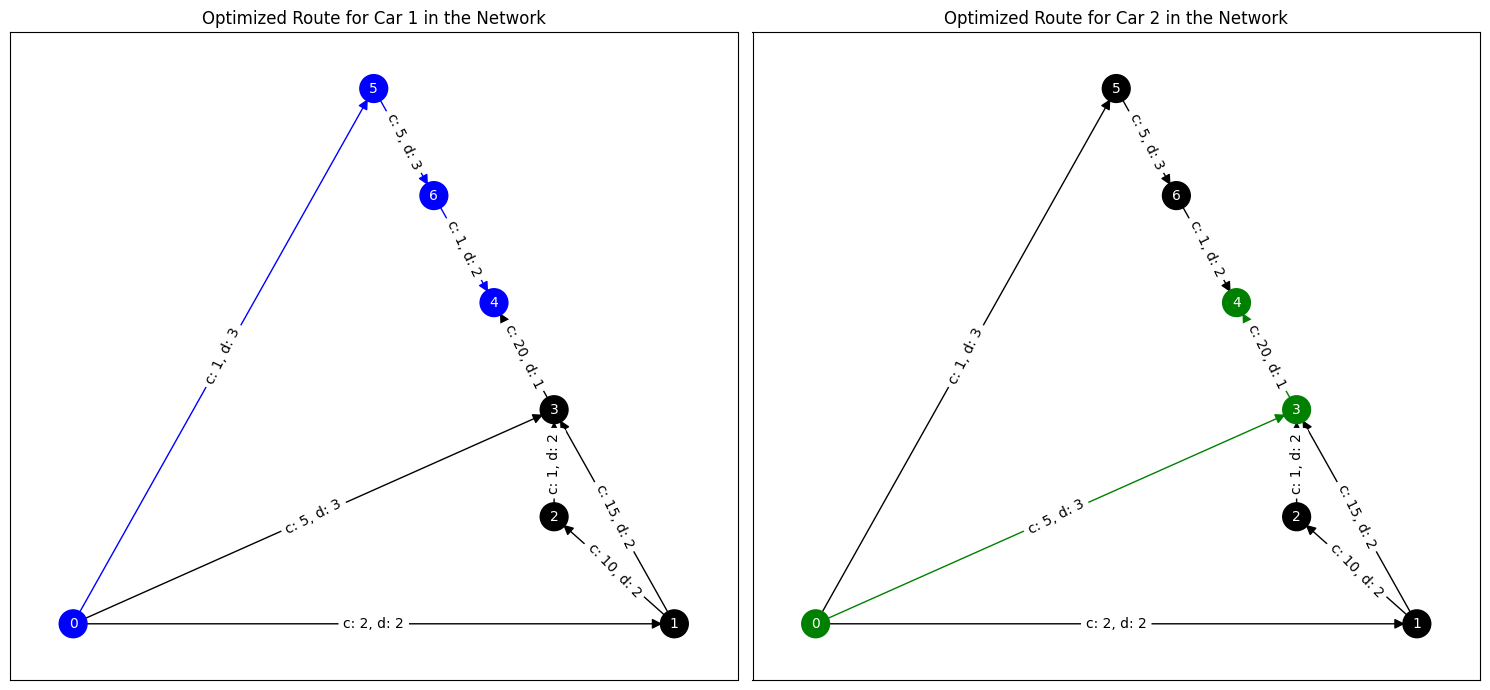

In [768]:
print("Best Solution")
print("Blue represent Car 1 , Green represents Car 2")
car1_edges = list(gp.utils.pairwise(car1_nodes))
car2_edges = list(gp.utils.pairwise(car2_nodes))
edge_labels = {(u, v): f'c: {d["congestion"]}, d: {d["distance"]}' for u, v, d in net.edges(data=True)}
fig, axes = plt.subplots(1, 2, figsize=(15, 7)) 
pos = gp.planar_layout(net)
#car1
node_colors = ['blue' if node in car1_nodes else 'black' for node in net.nodes()]
edge_colors = ['blue' if (u, v) in car1_edges else 'black' for u, v in net.edges()]
gp.draw_networkx_nodes(net, pos, node_color=node_colors, node_size=400,ax=axes[0])
gp.draw_networkx_edges(net, pos, edge_color = edge_colors, arrowstyle='-|>', arrowsize=15,ax=axes[0])
gp.draw_networkx_edge_labels(net, pos, edge_labels=edge_labels,ax=axes[0])
gp.draw_networkx_labels(net, pos, font_size=10, font_color='white',ax=axes[0])
axes[0].set_title("Optimized Route for Car 1 in the Network")

#car2
node_colors_car2 = ['green' if node in car2_nodes else 'black' for node in net.nodes()]
edge_colors_car2 = ['green' if (u, v) in car2_edges else 'black' for u, v in net.edges()]

gp.draw_networkx_nodes(net, pos, node_color=node_colors_car2, node_size=400, ax=axes[1])
gp.draw_networkx_edges(net, pos, edge_color=edge_colors_car2, arrowstyle='-|>', arrowsize=15, ax=axes[1])
gp.draw_networkx_edge_labels(net, pos, edge_labels=edge_labels,ax=axes[1])
gp.draw_networkx_labels(net, pos, font_size=10, font_color='white',ax=axes[1])
axes[1].set_title("Optimized Route for Car 2 in the Network")


plt.tight_layout()
plt.show()